In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from mergetree import *

## Basic Example

Below is an example of how to construct a time series and build a merge tree on top of it

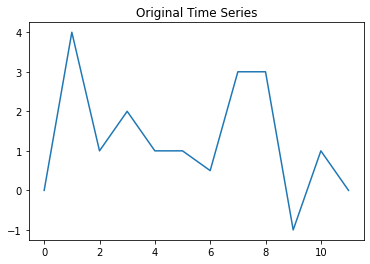

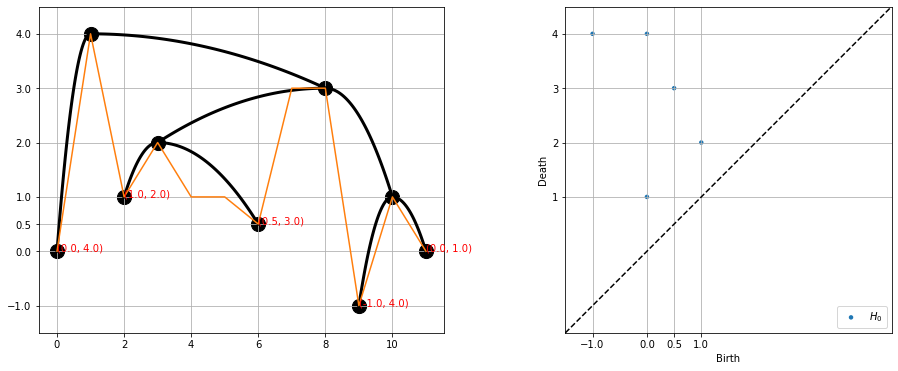

In [2]:
MT = MergeTree()
x = np.array([0, 4, 1, 2, 1, 1, 0.5, 3, 3, -1, 1, 0])
MT.init_from_timeseries(x)

plt.figure()
plt.plot(x)
plt.title("Original Time Series")

plt.figure(figsize=(16, 6))
MT.plot_with_pd(use_inorder=False, params={'use_grid':True, 'show_merge_xticks':True, 'plot_birthdeath':True})
plt.subplot(121)
plt.plot(x, c='C1')
plt.show()

One can compute the weight sequence conveniently from a method

In [3]:
print(MT.get_weight_sequence())

[4.  3.  1.5 4.  1. ]


## Equivalent PDs that aren't reflections

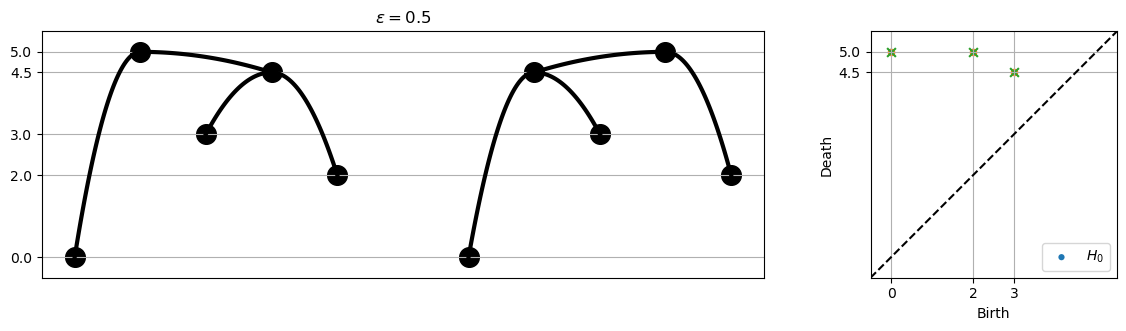

In [4]:
from persim import plot_diagrams
eps = 0.5
x1 = [5, 0, 5, 3, 5-eps, 2]
x2 = [5, 0, 5-eps, 3, 5, 2]

MT1 = MergeTree()
I1 = MT1.init_from_timeseries(x1)
MT2 = MergeTree()
I2 = MT2.init_from_timeseries(x2)

fac = 0.8
plt.figure(figsize=(fac*18, fac*4))
yvals = np.sort(np.unique(x1))
dy = yvals[-1] - yvals[0]

plt.subplot2grid((1, 3), (0, 0), colspan=2)
MT1.plot(True)
MT2.plot(True, params={'offset':np.array([6, 0])})
plt.gca().set_yticks(yvals)
plt.ylim(yvals[0]-0.1*dy, yvals[-1]+0.1*dy)
plt.gca().set_xticks([])
plt.grid()
plt.title("$\\epsilon = {}$".format(eps))

plt.subplot(133)
plot_diagrams(I1)
plt.scatter(I2[:, 0], I2[:, 1], 20)
plt.scatter(I2[:, 0], I2[:, 1], 40, marker='x')
plt.gca().set_yticks(np.unique(I1[:, 1]))
plt.ylim(yvals[0]-0.1*dy, yvals[-1]+0.1*dy)
plt.gca().set_xticks(np.unique(I1[:, 0]))
plt.xlim(yvals[0]-0.1*dy, yvals[-1]+0.1*dy)
plt.grid()

## Time Series -> Merge Tree -> Piecewise Linear Representative

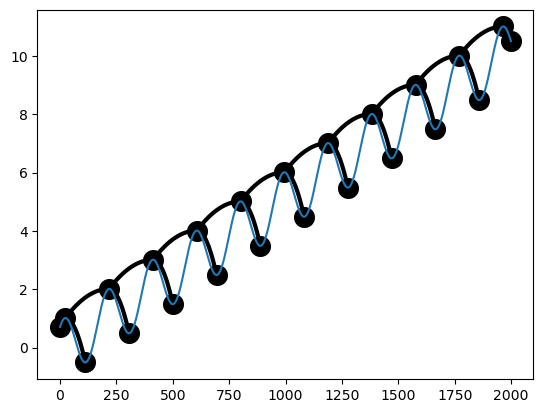

In [5]:
N = 2000
t = np.linspace(-0.1, 10.2, N)
y = np.cos(2*np.pi*t) + t

MT = MergeTree()
MT.init_from_timeseries(y)
MT.plot(use_inorder=False)
plt.plot(y)

Text(0.5, 1.0, 'Piecewise Linear')

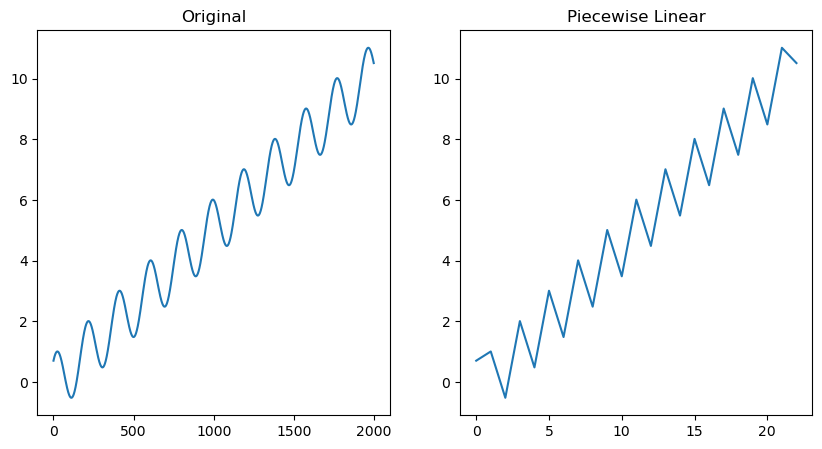

In [6]:
ylinear = MT.get_piecewise_linear_rep()
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(y)
plt.title("Original")
plt.subplot(122)
plt.plot(ylinear)
plt.title("Piecewise Linear")